In [1]:
# Source: https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec
## for data
import numpy as np
import pandas as pd
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for geospatial
import folium
import geopy
## for machine learning
from sklearn import preprocessing, cluster
import scipy
## for deep learning
import minisom

In [2]:
dtf = pd.read_csv('data_stores.csv')

In [3]:
filter = "Las Vegas"
dtf = dtf[dtf["City"]==filter][["City","Street Address","Longitude","Latitude"]].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={"index":"id"})
dtf.head()

,id,City,Street Address,Longitude,Latitude
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11


In [4]:
dtf["Potential"] = np.random.randint(low=3, high=10+1, size=len(dtf))
dtf["Staff"] = dtf["Potential"].apply(lambda x: int(np.random.rand()*x)+1)
dtf["Capacity"] = dtf["Potential"] - dtf["Staff"]
dtf["Cost"] = np.random.choice(["high","medium","low"], size=len(dtf), p=[0.4,0.5,0.1])
dtf.head()

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12,8,7,1,high
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04,7,5,2,high
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13,8,6,2,medium
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22,5,2,3,medium
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11,8,3,5,medium


In [5]:
# x = "Cost"
# ax = dtf[x].value_counts().sort_values().plot(kind="barh")
# totals = []
# for i in ax.patches:
#     totals.append(i.get_width())
# total = sum(totals)
# for i in ax.patches:
#      ax.text(i.get_width()+.3, i.get_y()+.20, 
#      str(round((i.get_width()/total)*100, 2))+'%', 
#      fontsize=10, color='black')
# ax.grid(axis="x")
# plt.suptitle(x, fontsize=20)
# plt.show()

In [6]:
city = "Las Vegas"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Las Vegas, Clark County, Nevada, United States of America
[lat, long]: [36.1672559, -115.1485163]


In [7]:
x, y = "Latitude", "Longitude"
color = "Cost"
size = "Staff"
popup = "Street Address"
data = dtf.copy()

## create color column
lst_colors=["red","green","orange"]
lst_elements = sorted(list(dtf[color].unique()))
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)

data.head()

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost,color,size
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12,8,7,1,high,red,11.000000
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04,7,5,2,high,red,8.333333
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13,8,6,2,medium,orange,9.666667
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22,5,2,3,medium,orange,4.333333
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11,8,3,5,medium,orange,5.666667


In [8]:
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

## plot the map
map_

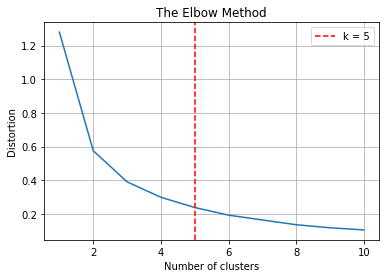

In [9]:
X = dtf[["Latitude","Longitude"]]
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [10]:
k = 5
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = dtf[["Latitude","Longitude"]]
## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
dtf.sample(5)

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost,cluster,centroids
86,86,Las Vegas,"2120 N. Rampart, Tropicana Beltway Center",-115.28,36.20,5,1,4,high,1,0
90,90,Las Vegas,"8975 S. Eastern Avenue, #A",-115.12,36.03,3,2,1,medium,3,0
145,145,Las Vegas,3700 W Flamingo Rd,-115.19,36.12,10,3,7,high,0,0
93,93,Las Vegas,3790 Las Vegas Blvd S,-115.18,36.10,5,3,2,high,0,0
33,33,Las Vegas,"5566 Boulder Highway, #2C",-115.05,36.10,3,1,2,medium,3,0


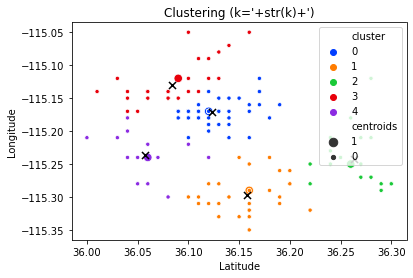

In [11]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="Latitude", y="Longitude", data=dtf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title("""Clustering (k='+str(k)+')""")
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

In [12]:
model = cluster.AffinityPropagation()

Text(0.5, 1.0, "Clustering (k='+str(k)+')")

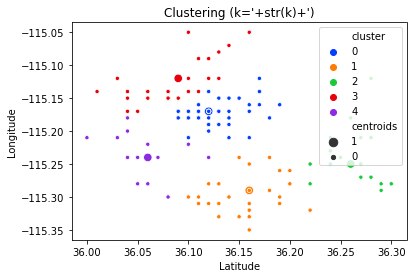

In [13]:
k = dtf["cluster"].nunique()
sns.scatterplot(x="Latitude", y="Longitude", data=dtf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief").set_title("""Clustering (k='+str(k)+')""")

In [14]:
x, y = "Latitude", "Longitude"
color = "cluster"
size = "Staff"
popup = "Street Address"
marker = "centroids"
data = dtf.copy()
## create color column
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
## add centroids marker
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           popup=row[marker], draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
## plot the map
map_

In [15]:
dtf_new = pd.DataFrame()
for c in sorted(dtf["cluster"].unique()):
    dtf_cluster = dtf[dtf["cluster"]==c]
    
    ## hubs and targets
    lst_hubs = dtf_cluster[dtf_cluster["Cost"]=="low"
               ].sort_values("Capacity").to_dict("records")
    lst_targets = dtf_cluster[dtf_cluster["Cost"]=="high"
               ].sort_values("Staff").to_dict("records")
    ## move targets
    for target in lst_targets:
         for hub in lst_hubs:
             ### if hub has space
             if hub["Capacity"] > 0:
                residuals = hub["Capacity"] - target["Staff"]
                #### case of hub has still capacity: do next target
                if residuals >= 0:
                    hub["Staff"] += target["Staff"]
                    hub["Capacity"] = hub["Potential"] - hub["Staff"]
                    target["Capacity"] = target["Potential"]
                    target["Staff"] = 0
                    break
                #### case of hub is full: do next hub
                else:
                    hub["Capacity"] = 0
                    hub["Staff"] = hub["Potential"]
                    target["Staff"] = -residuals
                    target["Capacity"] = target["Potential"] - target["Staff"]
    dtf_new = dtf_new.append(pd.DataFrame(lst_hubs)
                 ).append(pd.DataFrame(lst_targets))
dtf_new = dtf_new.append(dtf[dtf["Cost"]=="medium"]
                 ).reset_index(drop=True).sort_values(
                 ["cluster","Staff"])
dtf_new.head()

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost,cluster,centroids
5,96,Las Vegas,1925 N. Martin Luther King Blvd.,-115.16,36.19,3,0,3,high,0,0
6,34,Las Vegas,2411 West Sahara Ave,-115.18,36.14,7,0,7,high,0,0
7,42,Las Vegas,3799 Las Vegas blvd,-115.17,36.11,4,0,4,high,0,0
8,19,Las Vegas,3799 Las Vegas Blvd. South,-115.17,36.10,3,0,3,high,0,0
9,50,Las Vegas,3960 S. Las Vegas Blvd,-115.18,36.09,5,0,5,high,0,0


In [16]:
dtf_new["closed"] = dtf_new["Staff"].apply(lambda x: 1 
                                           if x==0 else 0)
print("closed:", dtf_new["closed"].sum())

closed: 11
